In [4]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
import time, math, random
from typing import Tuple
from sklearn.preprocessing import KBinsDiscretizer
env = gym.make('CartPole-v1')

In [5]:

policy = lambda obs: 0

for _ in range(5):
    obs = env.reset()
    for _ in range(80):
        actions = policy(obs)
        obs, reward, done, info = env.step(actions)
        env.render()
        time.sleep(0.05)

env.close()

C:\Users\finns\anaconda3\envs\hello-tf\lib\site-packages\gym\envs\classic_control\cartpole.py:151: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


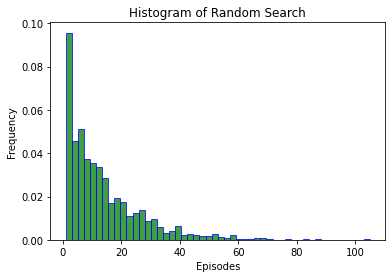

14.117


In [4]:
def run_episode(env, parameters):
    observation = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def train(submit):
    env = gym.make('CartPole-v1')
    if submit:
        env.monitor.start('cartpole-experiments/', force=True)

    counter = 0
    bestparams = None
    bestreward = 0
    for _ in range(10000):
        counter += 1
        parameters = np.random.rand(4) * 2 - 1
        reward = run_episode(env,parameters)
        if reward > bestreward:
            bestreward = reward
            bestparams = parameters
            if reward == 200:
                break

    if submit:
        for _ in xrange(100):
            run_episode(env,bestparams)
        env.monitor.close()

    return counter

# train an agent to submit to openai gym
# train(submit=True)

# create graphs
results = []
for _ in range(1000):
    results.append(train(submit=False))

plt.hist(results,50,density=True, facecolor='g', edgecolor='b', alpha=0.75)
plt.xlabel('Episodes')
plt.ylabel('Frequency')
plt.title('Histogram of Random Search')
plt.show()

print(np.sum(results) / 1000.0)

# Q-Learning Method: CartPole

In [33]:
n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

In [34]:
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape

(6, 12, 2)

In [35]:
def policy( state : tuple ):
    """Choosing action based on epsilon-greedy policy"""
    return np.argmax(Q_table[state])

In [36]:
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Temperal diffrence for updating Q-value of state-action pair"""
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

In [37]:
# Adaptive learning of Learning Rate
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    """Decaying learning rate"""
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

In [38]:
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Decaying exploration rate"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

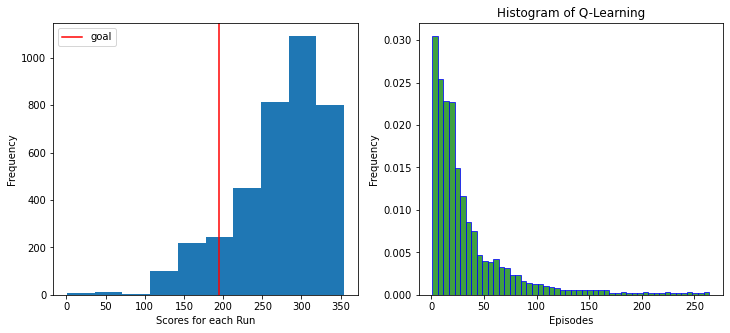

In [41]:
n_episodes = 100
results = []
values = []
for e in range(n_episodes):
    
    # Siscretize state into buckets
    current_state, done = discretizer(*env.reset()), False
    totalreward = 0
    
    while done==False:
        
        # policy action 
        action = policy(current_state) # exploit
        
        # insert random action
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # increment enviroment
        obs, reward, done, _ = env.step(action)
        totalreward += reward
        values.append(totalreward)
        
        new_state = discretizer(*obs)
        
        # Update Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        results.append(learnt_value)
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        
        current_state = new_state
        
        # Render the cartpole environment
        # env.render()
        
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].hist(results)
ax[0].axvline(195, c='red', label='goal')
ax[0].set_xlabel('Scores for each Run')
ax[0].set_ylabel('Frequency')
ax[0].legend()

plt.hist(values,50,density=True, facecolor='g', edgecolor='b', alpha=0.75)
plt.xlabel('Episodes')
plt.ylabel('Frequency')
plt.title('Histogram of Q-Learning')
plt.show()

# Cartpole with SARSA Learning

In [ ]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt 

env = gym.make("CartPole-v0")

#Environment values
print(env.observation_space.high)	#[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
print(env.observation_space.low)	#[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
print(env.action_space.n)			#2

#Hyperparamters
EPISODES = 30000
DISCOUNT = 0.95
EPISODE_DISPLAY = 500
LEARNING_RATE = 0.25
EPSILON = 0.2

#Q-Table of size theta_state_size*theta_dot_state_size*env.action_space.n
theta_minmax = env.observation_space.high[2] 
theta_dot_minmax = math.radians(50)
theta_state_size = 50
theta_dot_state_size = 50
Q_TABLE = np.random.randn(theta_state_size,theta_dot_state_size,env.action_space.n)

# For stats
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

def discretised_state(state):
    #state[2] -> theta
    #state[3] -> theta_dot
    discrete_state = np.array([0,0])		#Initialised discrete array
    theta_window =  ( theta_minmax - (-theta_minmax) ) / theta_state_size
    discrete_state[0] = ( state[2] - (-theta_minmax) ) // theta_window
    discrete_state[0] = min(theta_state_size-1, max(0,discrete_state[0]))

    theta_dot_window =  ( theta_dot_minmax - (-theta_dot_minmax) )/ theta_dot_state_size
    discrete_state[1] = ( state[3] - (-theta_dot_minmax) ) // theta_dot_window
    discrete_state[1] = min(theta_dot_state_size-1, max(0,discrete_state[1]))

    return tuple(discrete_state.astype(np.int))

for episode in range(EPISODES):
    episode_reward = 0
    done = False

    if episode % EPISODE_DISPLAY == 0:
        render_state = True
    else:
        render_state = False

    curr_discrete_state = discretised_state(env.reset())
    if np.random.random() > EPSILON:
        action = np.argmax(Q_TABLE[curr_discrete_state])
    else:
action = np.random.randint(0, env.action_space.n)

    while not done:
        new_state, reward, done, _ = env.step(action)
        new_discrete_state = discretised_state(new_state)

        if np.random.random() > EPSILON:
            new_action = np.argmax(Q_TABLE[new_discrete_state])
        else:
            new_action = np.random.randint(0, env.action_space.n)

        #if render_state:
        #	env.render()

        if not done:
            current_q = Q_TABLE[curr_discrete_state+(action,)]			
            max_future_q = Q_TABLE[new_discrete_state+(new_action,)]
            new_q = current_q + LEARNING_RATE*(reward+DISCOUNT*max_future_q-current_q)
            Q_TABLE[curr_discrete_state+(action,)]=new_q

        curr_discrete_state = new_discrete_state
        action = new_action

        episode_reward += reward

    ep_rewards.append(episode_reward)

    if not episode % EPISODE_DISPLAY:
        avg_reward = sum(ep_rewards[-EPISODE_DISPLAY:])/len(ep_rewards[-EPISODE_DISPLAY:])
        ep_rewards_table['ep'].append(episode)
        ep_rewards_table['avg'].append(avg_reward)
        ep_rewards_table['min'].append(min(ep_rewards[-EPISODE_DISPLAY:]))
        ep_rewards_table['max'].append(max(ep_rewards[-EPISODE_DISPLAY:]))
        print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-EPISODE_DISPLAY:])} max:{max(ep_rewards[-EPISODE_DISPLAY:])}")

env.close()

plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
plt.legend(loc=4) #bottom right
plt.title('CartPole SARSA')
plt.ylabel('Average reward/Episode')
plt.xlabel('Episodes')
plt.show()